In [5]:
%matplotlib inline
import pandas as pd
import urllib as ur
import json
import datetime
import matplotlib.pyplot as plt
import numpy as np

## Requisitando os carros e filtrando com base do seu tipo (normais, elétricos e híbridos).

Iremos coletar os ids de cada veículos e separá-los em movidos a gasolina, elétrico e híbrido.
Tal classificação tem como objetivo verificar o comportamento de uso para cada tipo de veículo.

In [14]:
# Requisição a lista de carros e suas informações
response = ur.request.urlopen('https://bookit.modo.coop/api/v2/car_list').read().decode('UTF-8')
json_cars = json.loads(response)

In [15]:
# Adquirindo os ids de todos os carros
car_ids = list(json_cars['Response']['Cars'].keys())

In [16]:
electric = []

# Separando por carro o seu tipo, sendo hibrido ou elétrico
for car in car_ids:
    try:
        accessories = list(json_cars['Response']['Cars'][str(car)]['Accessories'])

        if ('hybrid' in accessories):
            electric.append([int(car), 'hybrid'])
        if ('electric car' in accessories):
            electric.append([int(car), 'electric'])
    except:
        continue
        
# Lista com todos os veiculos elétricos e hibridos
electric = pd.DataFrame(electric, columns=['car_id', 'type'])

## Coletando a duração de cada viagem para carros normais, elétricos e híbridos.

In [ ]:
# Lendo csv de intervalos de ociosidade e ocupação
dfOccupied = pd.read_csv('occupied_v2.csv')
dfParked = pd.read_csv('parked_v2.csv')

In [18]:
def Hour_Diff(h1,h2):
    """
    Faz a diferença entre duas horas dadas e retorna em minutos
    
    Parameters
    ----------
    h1, h2 : unix timestamp
        Hora inicio e fim para ser feito o cálculo da diferença
        
    Returns
    ---------
    diff : float
        Diferença entre as duas horas dadas em minutos
        
    """
    
    h1Aux = datetime.datetime.fromtimestamp(h1)
    h2Aux = datetime.datetime.fromtimestamp(h2)
    diff = abs((h1Aux - h2Aux)).total_seconds()/60
    
    return diff

In [19]:
# Fazendo a duração de cada intervalo de ocupação
diff = []
for i in range(len(dfOccupied)):
    diff.append(Hour_Diff(dfOccupied['start'].iloc[i], dfOccupied['end'].iloc[i]))

diff = pd.DataFrame(diff, columns=['duration'])
Occupied_Diff = pd.concat([dfOccupied, diff], axis=1)

In [20]:
# Fazendo a duração de cada intervalo de tempo de ociosidade
diff = []
for i in range(len(dfParked)):
    diff.append(Hour_Diff(dfParked['start'].iloc[i], dfParked['end'].iloc[i]))

diff = pd.DataFrame(diff, columns=['duration'])
Parked_Diff = pd.concat([dfParked, diff], axis=1)

In [21]:
# Filtra os intervalos de ocupação dos carros híbridos e elétricos

electric_occupied = []
hybrid_occupied = []

for i in range(len(electric)):
    occupied = Occupied_Diff[Occupied_Diff['car_id'] == electric['car_id'].iloc[i]]

    if (electric['type'].iloc[i] == 'hybrid'):
        for j in range(len(occupied)):
            hybrid_occupied.append([occupied['car_id'].iloc[j] ,occupied['start'].iloc[j], 
                                   occupied['end'].iloc[j],occupied['duration'].iloc[j]])
        continue
    if (electric['type'].iloc[i] == 'electric'):
        for j in range(len(occupied)):
            electric_occupied.append([occupied['car_id'].iloc[j] ,occupied['start'].iloc[j], 
                                     occupied['end'].iloc[j], occupied['duration'].iloc[j]])
        continue

hybrid_occupied = pd.DataFrame(hybrid_occupied, columns=['car_id', 'start', 'end', 'duration'])
electric_occupied = pd.DataFrame(electric_occupied, columns=['car_id', 'start', 'end', 'duration'])

# Filtra o tempo de ociosidade dos carros híbridos e elétricos

electric_parked = []
hybrid_parked = []

for i in range(len(electric)):
    parked = Parked_Diff[Parked_Diff['car_id'] == electric['car_id'].iloc[i]]

    if (electric['type'].iloc[i] == 'hybrid'):
        for j in range(len(parked)):
            hybrid_parked.append([parked['car_id'].iloc[j] ,parked['start'].iloc[j], 
                                  parked['end'].iloc[j], parked['duration'].iloc[j]])
        continue
    if (electric['type'].iloc[i] == 'electric'):
        for j in range(len(parked)):
            electric_parked.append([parked['car_id'].iloc[j] ,parked['start'].iloc[j], 
                                    parked['end'].iloc[j], parked['duration'].iloc[j]])
        continue

hybrid_occupied = pd.DataFrame(hybrid_occupied, columns=['car_id', 'start', 'end', 'duration'])
electric_occupied = pd.DataFrame(electric_occupied, columns=['car_id', 'start', 'end', 'duration'])
hybrid_parked = pd.DataFrame(hybrid_parked, columns=['car_id', 'start', 'end', 'duration'])
electric_parked = pd.DataFrame(electric_parked, columns=['car_id', 'start', 'end', 'duration'])

In [22]:
# Filtrando tempo de ocupação e tempo de ociosidade de carros normais
normal_cars_occupied = []

for i in range(len(Occupied_Diff)):
    # Se o veiculo não está na lista dos elétricos e hibridos ele é a gasolina
    if (Occupied_Diff['car_id'].iloc[i] not in list(electric['car_id'])):
        normal_cars_occupied.append([Occupied_Diff['car_id'].iloc[i], Occupied_Diff['start'].iloc[i], 
                                    Occupied_Diff['end'].iloc[i], Occupied_Diff['duration'].iloc[i]])

normal_cars_occupied = pd.DataFrame(normal_cars_occupied, columns=['car_id', 'start', 'end', 'duration'])


normal_cars_parked = []

for i in range(len(Parked_Diff)):
    # Se o veiculo não está na lista dos elétricos e hibridos ele é a gasolina
    if (Parked_Diff['car_id'].iloc[i] not in list(electric['car_id'])):
        normal_cars_parked.append([Parked_Diff['car_id'].iloc[i], Parked_Diff['start'].iloc[i], 
                                    Parked_Diff['end'].iloc[i], Parked_Diff['duration'].iloc[i]])

normal_cars_parked = pd.DataFrame(normal_cars_parked, columns=['car_id', 'start', 'end', 'duration'])


## Plotagem dos CDFs.

Iremos plotar curvas de distribuições acumuladas a fim de verificar mais claramente a porcentagem de veículos ocupados para até dada duração de tempo de ocupação.

In [23]:
def cdf(df):
    """
    Calcula valores de todas as coordenadas (x,y) para uma CDF.
    
    Parameters
    -----------
    df : float list, pandas.DataFrame
        Lista de valores de durações para ser feita a CDF.
    
    Returns
    ---------
    x, y: float list
        Lista de todas as coordenadas da CDF.
        
    """
    
    df = df.sort_values(by='duration')
    values = df['duration']
    
    x = []
    y = []

    total = float(len(values))
    cnt = 0
    last = values.iloc[0]
    for data in values:
        if data != last:
            x.append(last)
            y.append(cnt/total)
            cnt += 1
            last = data
        else:
            cnt += 1
    x.append(last)
    y.append(cnt/total)
    
    return x, y

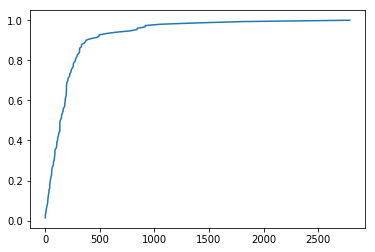

In [24]:
# CDF Ocupado de carros elétricos 
x, y = cdf(electric_occupied.sort_values(by='duration'))
plt.plot(x,y)

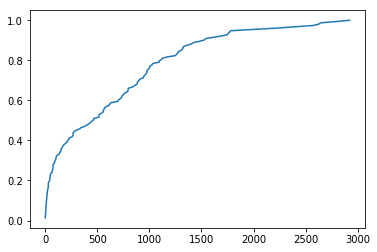

In [25]:
# CDF Ociosidade de carros elétricos
x, y = cdf(electric_parked.sort_values(by='duration'))
plt.plot(x,y)

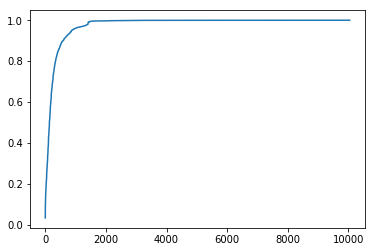

In [26]:
# CDF Ocupação de carros Híbridos
x, y = cdf(hybrid_occupied.sort_values(by='duration'))
plt.plot(x,y)

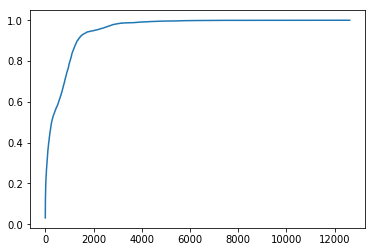

In [27]:
# CDF Ociosidade de carros Híbridos
x, y = cdf(hybrid_parked.sort_values(by=['duration']))
plt.plot(x,y)

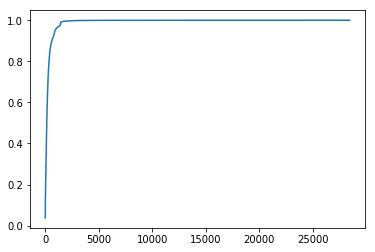

In [28]:
# CDF Ocupação de carros normais
x, y = cdf(normal_cars_occupied.sort_values(by=['duration']))
plt.plot(x,y)

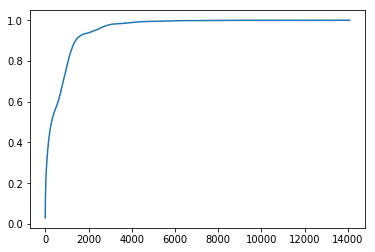

In [29]:
# CDF Viagens de carros normais
x, y = cdf(normal_cars_parked.sort_values(by='duration'))
plt.plot(x,y)

In [32]:
# Lendo dados após fitting

ocioso_pareto = pd.read_csv('Estacionado/1_pareto.csv', usecols=[1,2])
ocioso_weibull = pd.read_csv('Estacionado/1_weibull.csv', usecols=[1,2])
ocupado_pareto = pd.read_csv('Ocupado/1_pareto.csv', usecols=[1,2])
ocupado_weibull = pd.read_csv('Ocupado/1_weibull.csv', usecols=[1,2])
# ocupado_normal = pd.read_csv('Ocupado/1_lnorm.csv', usecols=[1,2])

In [33]:
# Selecionando somente os valores menores ou iguais a 5400 minutos
# assim padronizando as curvas a fim de facilitar a visualização e desconsiderar outliers

normal_cars_occupied = normal_cars_occupied[normal_cars_occupied['duration'] <= 5400]
normal_cars_parked = normal_cars_parked[normal_cars_parked['duration'] <= 5400]
electric_occupied = electric_occupied[electric_occupied['duration'] <= 5400]
electric_parked = electric_parked[electric_parked['duration'] <= 5400]
hybrid_occupied = hybrid_occupied[hybrid_occupied['duration'] <= 5400]
hybrid_parked = hybrid_parked[hybrid_parked['duration'] <= 5400]
ocioso_pareto = ocioso_pareto[ocioso_pareto['x'] <= 5400]
ocioso_weibull = ocioso_weibull[ocioso_weibull['x'] <= 5400]
ocupado_pareto = ocupado_pareto[ocupado_pareto['x'] <= 5400]
ocupado_weibull = ocupado_weibull[ocupado_weibull['x'] <= 5400]
# ocupado_normal = ocupado_normal[ocupado_normal['x'] <= 5400]

In [ ]:


fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(14,4.5)
# Plot do tempo ocupado

x, y = cdf(normal_cars_occupied.sort_values(by=['duration']))
ax1.plot(x,y, label='Comuns', marker='o', markevery=[470,1000,1800,2500,3600,5000,6300,7200,
                                                     7350,7400,7500])


x, y = cdf(electric_occupied.sort_values(by='duration'))
ax1.plot(x,y, label='Elétricos', marker='^', markevery=[10,35,70,90,130,150,170,190,195,198,
                                                        200,201])


x, y = cdf(hybrid_occupied.sort_values(by='duration'))
ax1.plot(x,y, label='Híbridos', marker='s', markevery=[150,450,750,1200,1800,2500,3000,3300,
                                                       3500,3520,3540,3570])

ax1.plot(ocupado_pareto['x'], ocupado_pareto['y'], label='Fitted Pareto', linestyle='--')

ax1.plot(ocupado_weibull['x'], ocupado_weibull['y'], label='Fitted Weibull', c='black', linestyle=':')

# ax1.plot(ocupado_normal['x'], ocupado_normal['y'], label='Fitted Normal', c='purple', linestyle='-.')

# Modificando os labels dos minutos
ax1.xaxis.set_ticks(np.arange(0, 6000, 720))

fig.canvas.draw()

labels = [item.get_text() for item in ax1.get_xticklabels()]
labels = range(0,100,12)

ax1.set_xticklabels(labels)

ax1.legend(bbox_to_anchor=(0.65, 0.35), loc=2, borderaxespad=0.2)
ax1.set_ylabel('ECDF')
ax1.set_xlabel('Tempo Ocupado [horas]')


# Plot do tempo ocioso

x, y = cdf(normal_cars_parked.sort_values(by='duration'))
ax2.plot(x,y, label='Comuns', marker='o', markevery=[100,900,1800,3400,5500,7200,9100,10700,
                                                     11800,12500,13050])

x, y = cdf(electric_parked.sort_values(by='duration'))
ax2.plot(x,y, label='Elétricos', marker='^', markevery=[25,83,100,120,145,170,190,200,206,210])

x, y = cdf(hybrid_parked.sort_values(by='duration'))
ax2.plot(x,y, label='Híbridos', marker='s', markevery=[150,650,1200,2000,2900,3800,4400,4750,
                                                       5080,5180,5250])

ax2.plot(ocioso_pareto['x'], ocioso_pareto['y'], label='Fitted Pareto', linestyle='--')

ax2.plot(ocioso_weibull['x'], ocioso_weibull['y'], label='Fitted Weibull', c='black', linestyle=':')


# Modificando os labels dos minutos para horas
ax2.xaxis.set_ticks(np.arange(0, 6000, 720))

fig.canvas.draw()

labels = [item.get_text() for item in ax2.get_xticklabels()]
labels = range(0,100,12)

ax2.set_xticklabels(labels)

ax2.legend(bbox_to_anchor=(0.65, 0.35), loc=2, borderaxespad=0.2)
ax.set_ylabel('ECDF of rental duration')
ax.set_xlabel('Busy Time [hours]')

# ax1.grid(b=True, linestyle='--')
# ax2.grid(b=True, linestyle='--')

plt.savefig('CDFs_v2.pdf', bbox_inches='tight')

## Tarde e noite para dias de semana

Estamos separando as reservas que iniciaram em certos horários, que foram observados como de pico em dias de semana, sendo o intervalo de 11 AM até 4 PM e de 7 PM até 8 PM.

In [23]:
tarde = []
noite = []

for i in range(len(Occupied_Diff)):
    start = Occupied_Diff['start'].iloc[i]
    hora = datetime.datetime.fromtimestamp(start).hour
    dia = int(datetime.datetime.fromtimestamp(start).strftime('%w'))
    
    if ((hora >= 11 and hora <= 16) and (dia > 0 and dia < 6)):
        tarde.append([Occupied_Diff['car_id'].iloc[i], Occupied_Diff['start'].iloc[i], 
                      Occupied_Diff['duration'].iloc[i]])
    
    elif ((hora >= 19 and hora <= 20) and (dia > 0 and dia < 6)):
        noite.append([Occupied_Diff['car_id'].iloc[i], Occupied_Diff['start'].iloc[i], 
                      Occupied_Diff['duration'].iloc[i]])

tarde = pd.DataFrame(tarde, columns=['car_id', 'start', 'duration'])
noite = pd.DataFrame(noite, columns=['car_id', 'start', 'duration'])

In [24]:
# Durações menores que 66 horas
tarde = tarde[tarde['duration'] < 4000]
noite = noite[noite['duration'] < 4000]

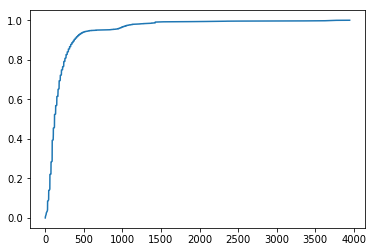

In [25]:
x, y = cdf(tarde.sort_values(by='duration'))
plt.plot(x,y)

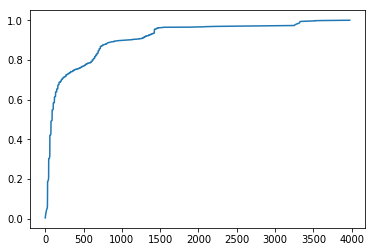

In [26]:
x, y = cdf(noite.sort_values(by='duration'))
plt.plot(x,y)

In [27]:
# Durações menores ou iguais que 28 horas, a fim de facilitar a visualização e eliminar outliers
tarde = tarde[tarde['duration'] <= 28*60]
noite = noite[noite['duration'] <= 28*60]
todos = Occupied_Diff[Occupied_Diff['duration'] <= 28*60]

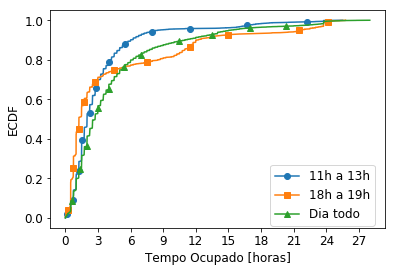

In [28]:
import matplotlib

matplotlib.rc('font', size=12)

fig, ax = plt.subplots()

x, y = cdf(tarde.sort_values(by='duration'))
ax.plot(x,y, label='11AM to 4PM', marker='o', markevery=[30,280,530,820,1100,1650,2100,2500,
                                                       2750,3100,3350,3450])

x, y = cdf(noite.sort_values(by='duration'))
ax.plot(x,y, label='7PM to 8PM', marker='s', markevery=[30,80,120,190,280,340,390,450,465,500])

x, y = cdf(todos.sort_values(by='duration'))
ax.plot(x,y, label='All day', marker='^', markevery=[350,960,1400,2200,2800,3600,4300,5500,
                                                      6300,7100,7400])

# Modificando os labels dos minutos
ax.xaxis.set_ticks(np.arange(0, 1800, 180))

fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = range(0,30,3)

ax.set_xticklabels(labels)

ax.legend(bbox_to_anchor=(0.6, 0.3), loc=2, borderaxespad=0.2)
ax.set_ylabel('ECDF of rental duration')
ax.set_xlabel('Busy Time [hours]')

# plt.grid(b=True, linestyle='--')

plt.savefig('tarde_noiteCDF_v2.pdf')